In [ ]:
from src.v1.symbolic import Var, Par, ureg
from src.v1.mdaocomps import Evaluable, buildidpvars
from src.v2.nesting import Model, adda, addf
from src.v2.nesting import RefNode, SolverNode, addsolver, geteqs, INTER
from src.v1.inputresolver import reassigneq, eqvars, eqsonly, default_out, default_in
from src.v1.presolver import mdf_order, resolve, flatten_order
from src.v1.inputresolver import getallvars, invert_edges, reassign
from graph.graphview import bipartite_repr, drawbipartite, digraph_repr, draw, draw_dsm, tree_incidence, drawfull, render_tree
from src.v1tree.notation import generate_execution, graphs_from_incidence, make_acyclic, default_sequence
from anytree import PreOrderIter
import sympy as sp
import numpy as np
import openmdao.api as om

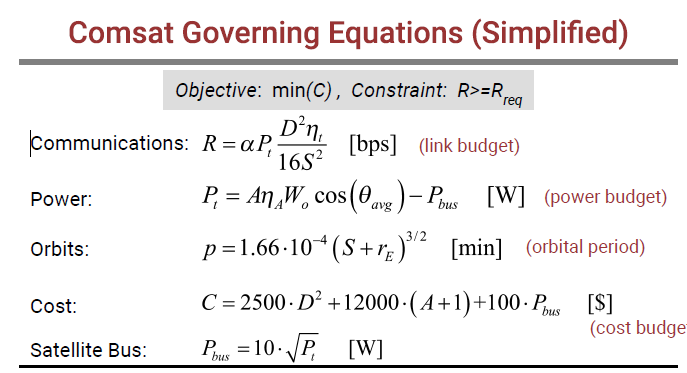

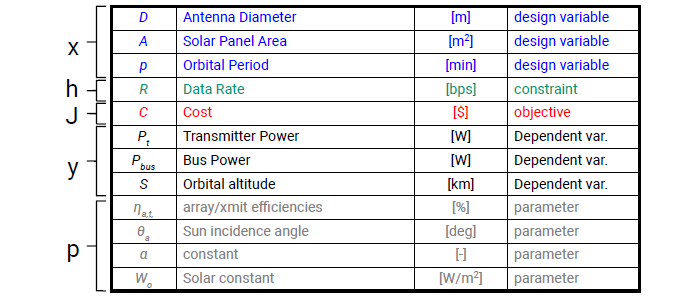

In [2]:
ureg.define('USD = [currency] ')

In [3]:
model = Model()
m = RefNode(name='/', ref=model)
P_t = Var('P_t', unit='W')
Pbus = Var('P_b', unit='W')
S = Var('S', 400, unit='km')
D = Var('D', 0.1, unit='m')
A = Var('A', 0.5, unit='m^2')
eta_t = Par('eta', 0.5)
eta_a = Par('eta', 0.3)
alpha = Par('alpha', 1e20, 'bits/W')
th = Par('theta_a', np.pi/4)
W0 = Par('W_0', 1367, 'W/m^2')
Re = Par('Re', 6378, 'km')
μ = Par('mu', 3.986005e14, 'm^3/s^2')
c1 = Par('c1', 2500, 'USD/m^2')
c2 = Par('c2', 12000, 'USD/m^2')
c3 = Par('c3', 100, 'USD/W')
c4 = Par('c4', 12000, 'USD')
Rreq = Par('R_r', 2, 'MB')
p = adda(m, 'p', 2*np.pi*((S+Re)**3/μ)**0.5, unit='min', returnfx=True)
C = adda(m, 'C', c1*D**2+c2*A+c3*Pbus+c4, returnfx=True)
adda(m, Pbus, P_t)
_, f4 = adda(m, P_t, A*eta_a*W0*sp.cos(th)-Pbus, returnfx=True)
R, f5 = adda(m, 'R', alpha*P_t*D**2*eta_t/(16*S**2), unit='MB', returnfx=True)
r6 = addf(m, R-10);

In [4]:
s1 = addsolver(m, [elt for elt in PreOrderIter(m) if elt.node_type==INTER], [(r6, A)])

## Simpler model

In [5]:
model_optinc = Model()
m2 = RefNode(name='/', ref=model_optinc)
p = adda(m2, 'p', 2*np.pi*((S+Re)**3/μ)**0.5, unit='min', returnfx=True)
C = adda(m2, 'C', c1*D**2+c2*A+c3*Pbus+c4, returnfx=True)
adda(m2, Pbus, P_t)
left,right = model.eqs[f4]
adda(m2, A, sp.simplify(reassigneq(left, right, A)))
left,right = model.eqs[f5]
adda(m2, P_t, sp.simplify(reassigneq(left, right, P_t)))
adda(m2, R, sp.simplify(reassigneq(None, R-10, R)))

# Get order

In [6]:
G, graphs = graphs_from_incidence(m, from_root=True)
m_order = make_acyclic(m, graphs)

In [7]:
G, graphs = graphs_from_incidence(m2, from_root=True)
m_order2 = make_acyclic(m2, graphs)

In [8]:
render_tree(m_order, display_type=True)

/               
└── ., SOLVER   
    ├── 0, INTER
    ├── ., SOLVER
    │   ├── 2, END
    │   └── 3, END
    ├── 1, INTER
    └── 4, INTER


In [9]:
eqs, eqv, dout, dins = model.data_structures()
_, eqv_optinc, _, _ = model_optinc.data_structures()

In [10]:
circular_m = default_sequence(m)
sequence_m = default_sequence(m_order)
sequence_m2 = default_sequence(m_order2)

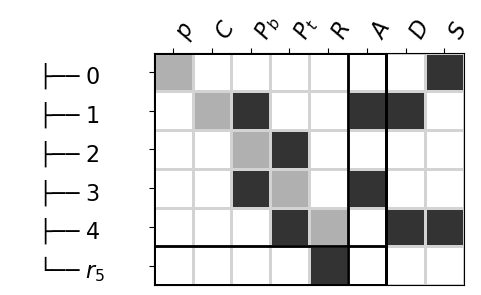

In [11]:
tree_incidence(m, eqv, model.outset, circular_m, figsize=(4,4));

In [12]:
order = mdf_order(eqv, dout)

In [14]:
eqv_noparams = {elt:{key for key in keys if not key.always_input} for elt,keys in eqv.items()}
DG, edges = digraph_repr(eqv_noparams, dout, intermediary=False)

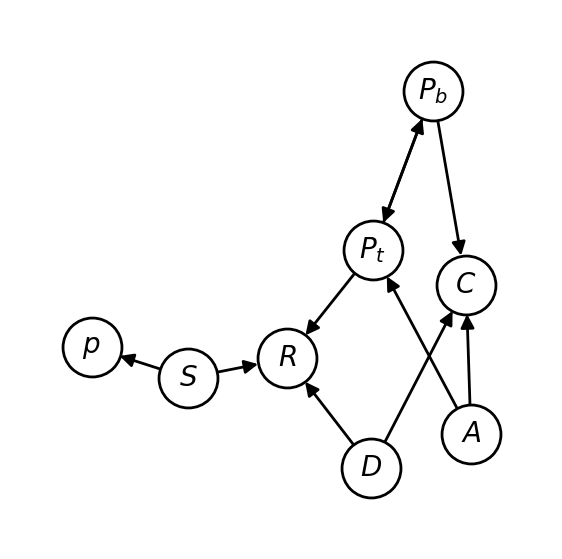

In [16]:
draw(DG, figsize=(7,7), node_shape='o', prog='neato', node_size=1800);

In [17]:
order

[0, (2, 3), 1, 4]

In [20]:
newins = (set(dins)-{A}).union({Rreq})

In [21]:
newins

{D, R_r, Re, S, W_0, alpha, c1, c2, c3, c4, eta, mu, theta_a}

In [22]:
from src.v1.mdaocomps import coupled_run

In [23]:
prob = om.Problem()
model = prob.model
dins = default_in(eqs)
buildidpvars(newins, model)
bal = model.add_subsystem('res', om.BalanceComp(), promotes=['A'])
bal.add_balance('A')
model.connect('R', 'res.rhs:A')
model.connect('R_r', 'res.lhs:A')
model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
model.linear_solver = om.DirectSolver()
counter = coupled_run(eqs, order, (), model, model)
model.group1.group2.nonlinear_solver = om.NonlinearBlockGS()
prob.setup()
prob.set_solver_print(level=1)
prob.run_model()

NL: Newton Converged in 4 iterations


In [25]:
model.list_outputs();

18 Explicit Output(s) in 'model'

varname    val             
---------  ----------------
inp
  Re       [6378.]         
  D        [0.1]           
  W_0      [1367.]         
  mu       [3.986005e+14]  
  c1       [2500.]         
  c3       [100.]          
  R_r      [2.]            
  S        [400.]          
  eta      [0.3]           
  theta_a  [0.78539816]    
  c4       [12000.]        
  c2       [12000.]        
  alpha    [1.e+20]        
group1
  eq0
    p      [92.55759153]   
  group2
    eq2
      P_b  [136.53332048]  
    eq3
      P_t  [136.53332048]  
  eq1
    C      [36978.24564216]
  eq4
    R      [1.99999981]    


1 Implicit Output(s) in 'model'

varname  val         
-------  ------------
res
  A      [0.94165947]




In [26]:
vrs =getallvars(eqs)

In [27]:
vrs

{A,
 C,
 D,
 None,
 P_b,
 P_t,
 R,
 Re,
 S,
 W_0,
 alpha,
 c1,
 c2,
 c3,
 c4,
 eta,
 mu,
 p,
 theta_a}

In [28]:
order

[0, (2, 3), 1, 4]

In [29]:
B, edges = bipartite_repr(eqv)

In [30]:
newdout = resolve(eqs, vrs, invert_edges(edges), maxiter=1, not_input=None)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-13


In [31]:
newdout

[{'C': [],
  'OBJ': 0.0,
  'CLEN': [],
  'SOL': [(0, mu), (1, c3), (2, P_b), (3, A), (4, alpha), (r_{5}, R)]}]